In [1]:
pip install pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('URL_data.csv')

# Inspect the first few rows
print(df.head())


                                                 url  length_url  \
0  https://www.todayshomeowner.com/how-to-make-ho...          82   
1  http://thapthan.ac.th/information/confirmation...          93   
2  http://app.dialoginsight.com/T/OFC4/L2S/3888/B...         121   
3                           https://www.bedslide.com          24   
4  https://tabs.ultimate-guitar.com/s/sex_pistols...          73   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               23   0        2           7      0      0       0      0  ...   
1               14   1        2           0      0      0       0      0  ...   
2               21   1        3           0      0      0       0      0  ...   
3               16   0        2           0      0      0       0      0  ...   
4               24   0        3           1      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                1                

In [5]:
print(df.info())
print(df['status'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])  # 'legitimate' -> 1, 'phishing' -> 0 (or vice versa)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = df.drop(columns=['url', 'status'])  # Drop URL and target column
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



model = RandomForestClassifier(max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9619422572178478
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1133
           1       0.96      0.96      0.96      1153

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286



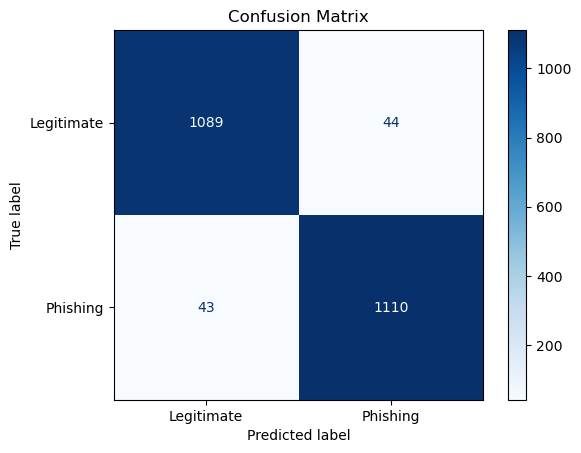

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


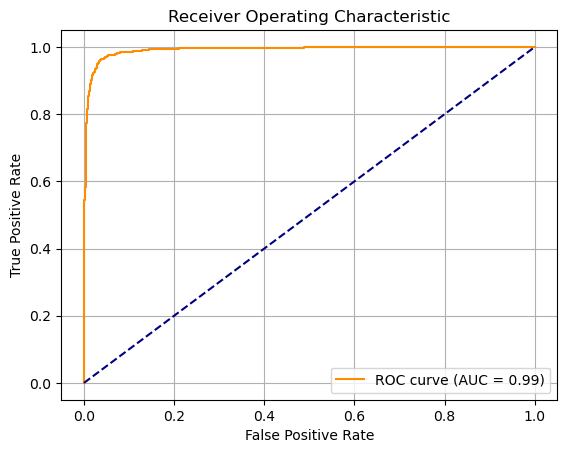

In [14]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [15]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Train accuracy: 0.9805
Test accuracy: 0.9619


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up GridSearchCV
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Evaluate on test set
test_score = grid.score(X_test, y_test)
print("Test accuracy with best parameters:", test_score)


Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.96445684827356
Test accuracy with best parameters: 0.9671916010498688


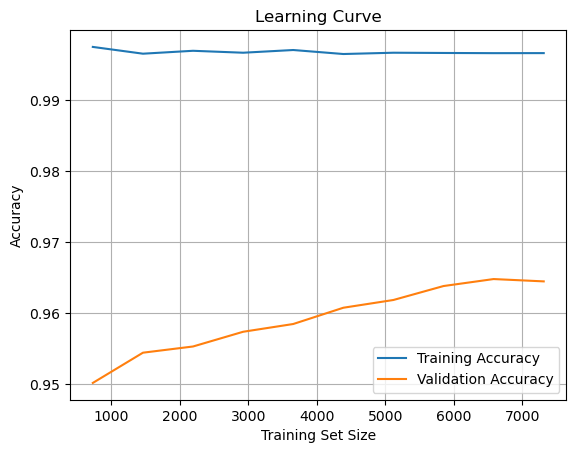

In [17]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid.best_estimator_,  # or model if not using GridSearch
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


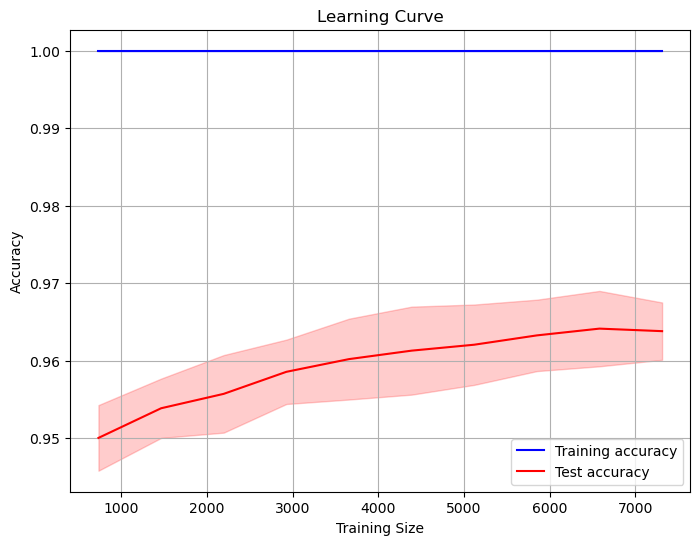

In [18]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Get the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Calculate mean and std deviation for training and test scores
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Test accuracy', color='red')

# Add fill between for the std deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

# Add labels and legend
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [19]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


C:\Users\Divyashree G P\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.968941382327209

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1133
           1       0.97      0.97      0.97      1153

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



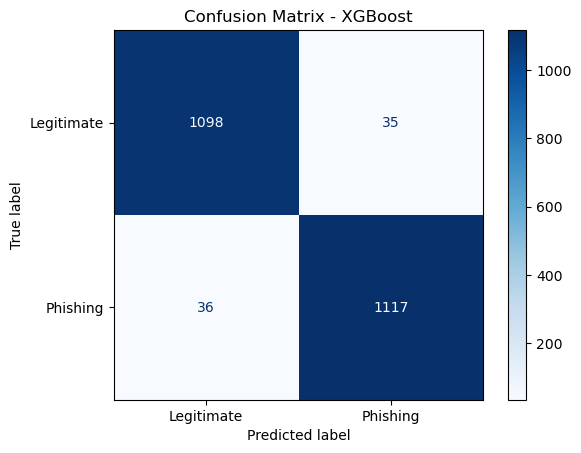

In [22]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)  # No need for use_label_encoder
xgb_model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm, display_labels=["Legitimate", "Phishing"]).plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), params, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

print("Best parameters:", grid_xgb.best_params_)
print("Best cross-validation accuracy:", grid_xgb.best_score_)
print("Test accuracy with best parameters:", grid_xgb.score(X_test, y_test))


C:\Users\Divyashree G P\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:38:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Divyashree G P\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:38:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Divyashree G P\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:38:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Divyashree G P\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:38:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encode

Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Best cross-validation accuracy: 0.9685035526581828
Test accuracy with best parameters: 0.9658792650918635


In [23]:
import joblib
joblib.dump(xgb_model, "xgboost_url_classifier.pkl")


['xgboost_url_classifier.pkl']

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1133
           1       0.97      0.97      0.97      1153

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



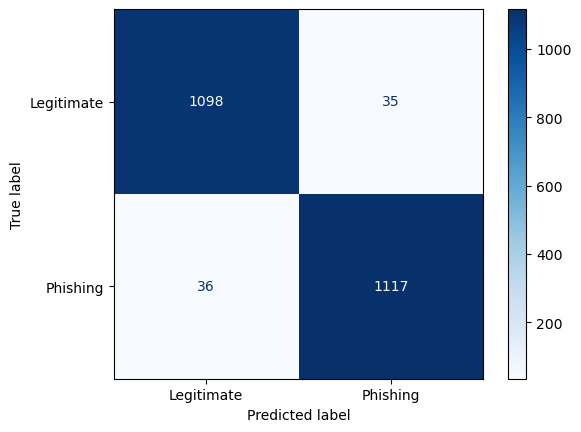

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap="Blues")


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1133
           1       0.97      0.97      0.97      1153

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



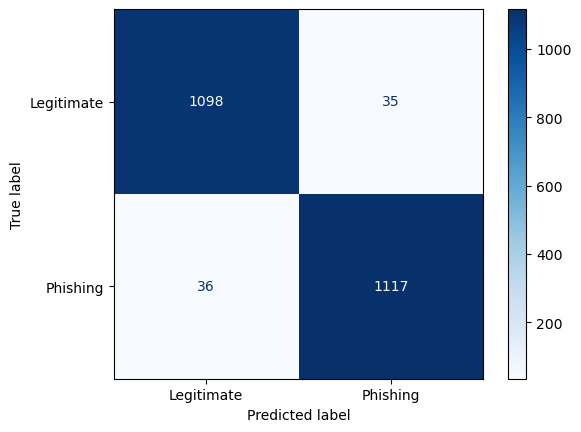

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap="Blues")


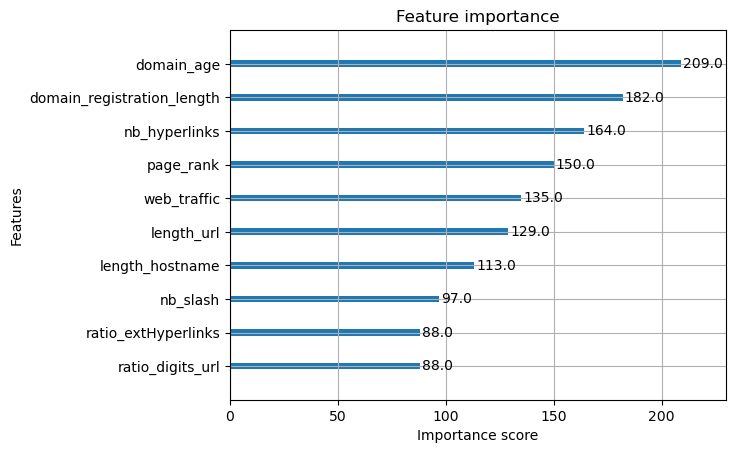

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, max_num_features=10)
plt.show()


              precision    recall  f1-score   support

           0       0.75      0.32      0.45      1133
           1       0.57      0.90      0.70      1153

    accuracy                           0.61      2286
   macro avg       0.66      0.61      0.57      2286
weighted avg       0.66      0.61      0.57      2286



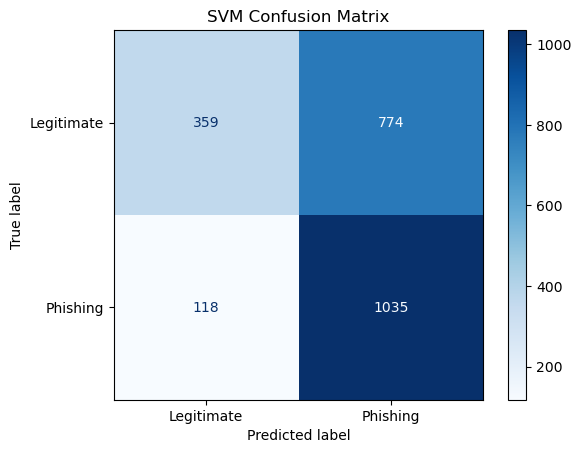

Train accuracy: 0.5972
Test accuracy: 0.6098


In [27]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create and train the SVM model
svm_model = SVC(kernel='rbf', random_state=42)  # You can try 'linear' or 'poly' kernels too
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_svm))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.show()

# Check accuracy
train_acc = svm_model.score(X_train, y_train)
test_acc = svm_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),   # if scaling needed
    ('xgb', XGBClassifier(
        learning_rate=0.2, max_depth=4, n_estimators=200, random_state=42, eval_metric='logloss'
    ))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

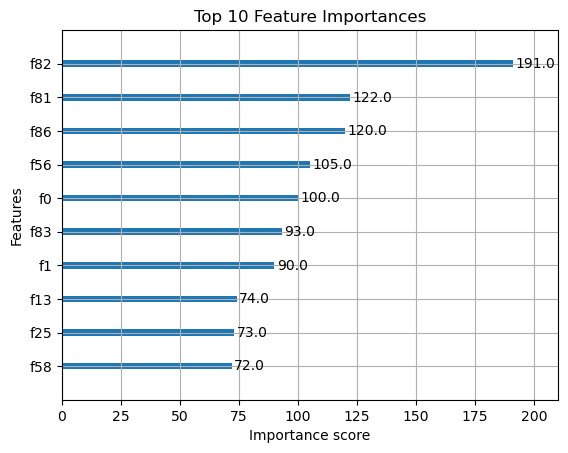

In [29]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(pipeline.named_steps['xgb'], max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


In [30]:
import joblib

# Save
joblib.dump(pipeline, 'xgb_phishing_model.pkl')

# Later, load it
loaded_pipeline = joblib.load('xgb_phishing_model.pkl')


In [31]:
y_pred = loaded_pipeline.predict(X_test)


In [32]:
new_urls = pd.DataFrame({
    'url': [
        "http://examplephishingsite.com/login",
        "https://legitimatewebsite.com/home",
        "http://some-suspicious-site.net"
    ]
})


In [33]:
predictions = pipeline.predict(new_urls)
print(predictions)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- url
Feature names seen at fit time, yet now missing:
- abnormal_subdomain
- avg_word_host
- avg_word_path
- avg_words_raw
- brand_in_path
- ...
